## UM-MAE: Visualization Demo

This is a visualization demo using our pre-trained UM-MAE/SimMIM models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('..')
import models_mae_swin
import models_simmim_swin
from mask_transform import RandomMaskingGenerator

### Define utils

In [6]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    if title is not None:
        plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model_mae_swin(chkpt_dir, arch='mae_swin_tiny_256_dec512d2b', vis_mask_ratio=0.25):
    # build model
    model = getattr(models_mae_swin, arch)(vis_mask_ratio=vis_mask_ratio)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def prepare_model_simmim_swin(chkpt_dir, arch='simmim_swin_tiny_256_dec512d2b'):
    # build model
    model = getattr(models_simmim_swin, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image_mae(img, model, s=16, return_fig=False):
    # Note that it is the normalized-pixel version um-mae models
    # So we need the mean/variance of original images for reconstruction
    # For better reconstruction results, we suggest to pre-train um-mae models using unnormalized-pixel version, 
    # and comment the mean/variance part here in this function for visualization.
    # Currently, we have not pre-trained the unnormalized-pixel version due to resource limiation.
    # We are welcome for PRs with updated unnormalized-pixel checkpoints
    x = torch.tensor(img)
    h = x.size(1) // s

    mask_generator = RandomMaskingGenerator(h, 0.75, True)
    mask = torch.tensor(mask_generator()).to(x.device).to(torch.bool).unsqueeze(0)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    px = model.patchify(x, s)
    px_mean = px.mean(dim=-1, keepdim=True)
    px_var = px.var(dim=-1, keepdim=True)
    # run UM-MAE
    loss, y, mask = model(x.float(), mask)
    
    B = torch.tensor(range(0, h*h)).to(x.device).unsqueeze(0)
    order = mask.float() * 1000 + B
    ids = torch.argsort(order, dim=1)
    ids_ = torch.argsort(ids, dim=1)
    y = torch.gather(y, dim=1, index=ids_.unsqueeze(-1).expand(-1, -1, y.size(-1)))
    # unnormalize y
    y = y * (px_var + 1.e-6)**.5 + px_mean
    y = model.unpatchify(y, s)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, s**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask, s)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask.float())

    # reconstruction pasted with visible patches
    im_paste = x * (1 - mask.float()) + y * mask

    if return_fig:
        return x[0], im_masked[0], im_paste[0]

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 3, 1)
    show_image(x[0], "original")

    plt.subplot(1, 3, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 3, 3)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

def run_one_image_simmim(img, model, s=16, return_fig=False):
    x = torch.tensor(img)
    h = x.size(1) // s

    mask_generator = RandomMaskingGenerator(h, 0.75, True)
    mask = torch.tensor(mask_generator()).to(x.device).to(torch.bool).unsqueeze(0)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run simmim
    loss, y, mask = model(x.float(), mask)

    y = model.unpatchify(y, s)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, s**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask, s)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask.float())

    # reconstruction pasted with visible patches
    im_paste = x * (1 - mask.float()) + y * mask

    if return_fig:
        return x[0], im_masked[0], im_paste[0]

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 3, 1)
    show_image(x[0], "original")

    plt.subplot(1, 3, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 3, 3)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

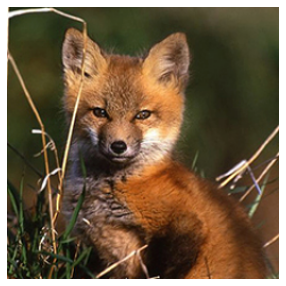

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img_size = 256
img = img.resize((img_size, img_size))
img = np.array(img) / 255.

assert img.shape == (img_size, img_size, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load pre-trained UM-MAE and SimMIM models

In [4]:
## download checkpoint if not exist, we provide 800-epoch checkpoint for this demo
# chkpt_dir_mae    is in https://drive.google.com/file/d/1OF8OACBJKBaA4VI_4ssvJQD4dxnflf4s/view?usp=sharing
# chkpt_dir_simmim is in https://drive.google.com/file/d/1jL7N00I2x6v3T_IJ8hPJb8tIB3Bx1qUa/view?usp=sharing
# download them to ../work_dirs/

chkpt_dir_mae    = '../work_dirs/checkpoint-799_mae_swin_tiny_256-model.pth'
chkpt_dir_simmim = '../work_dirs/checkpoint-799_simmim_swin_tiny_256-model.pth'

model_mae_swin = prepare_model_mae_swin(chkpt_dir_mae, 'mae_swin_tiny_256', vis_mask_ratio=0.25)
print('UM-MAE Swin-T Model loaded.')
model_simmim_swin = prepare_model_simmim_swin(chkpt_dir_simmim, 'simmim_swin_tiny_256')
print('SimMIM Swin-T Model loaded.')

vis_mask_token is learnable
<All keys matched successfully>
UM-MAE Swin-T Model loaded.
<All keys matched successfully>
SimMIM Swin-T Model loaded.


### Run UM-MAE and SimMIM on the image

UM-MAE with pixel reconstruction:
using regular, mask_candidate shape =  (128, 4)


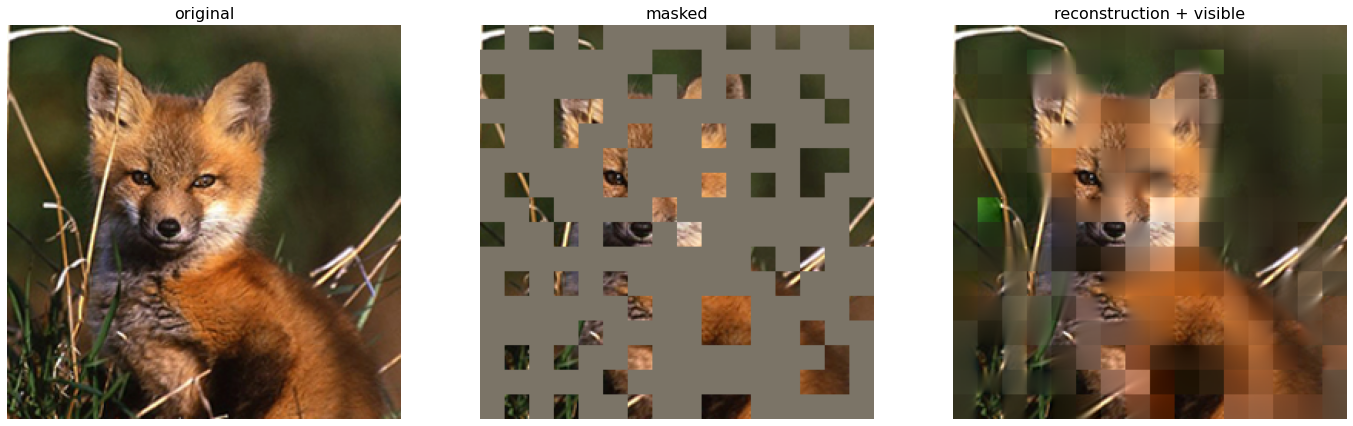

SimMIM with pixel reconstruction:
using regular, mask_candidate shape =  (128, 4)


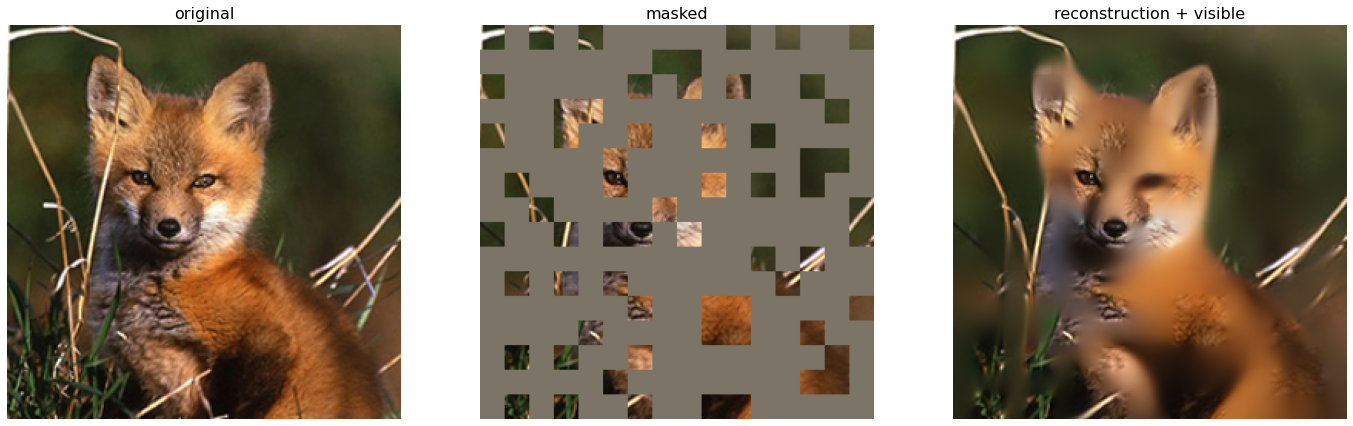

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(1)
np.random.seed(2)
print('UM-MAE with pixel reconstruction:')
run_one_image_mae(img, model_mae_swin)

torch.manual_seed(1)
np.random.seed(2)
print('SimMIM with pixel reconstruction:')
run_one_image_simmim(img, model_simmim_swin)